# Let's go!
## Imports and Set Up
___

In [1]:
!pip install skrub skore optuna_integration --upgrade scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.4/340.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you h

In [2]:
# %load_ext cuml.accel

In [3]:
import warnings
from copy import deepcopy
from pathlib import Path
from dataclasses import dataclass
from typing import Union, Optional, Final

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, check_is_fitted, clone
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import (
    HistGradientBoostingClassifier, HistGradientBoostingRegressor,
    ExtraTreesRegressor, RandomForestRegressor
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    root_mean_squared_log_error, root_mean_squared_error, roc_auc_score, make_scorer
)
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, GroupKFold
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

import skrub, skore

import catboost as cb

import optuna
from optuna.samplers import TPESampler

In [4]:
!wget https://raw.githubusercontent.com/semyonbok/scikit-learn-crafts/refs/heads/master/src/crafts/regressors.py

from regressors import GroupRegressor

--2025-06-19 20:47:52--  https://raw.githubusercontent.com/semyonbok/scikit-learn-crafts/refs/heads/master/src/crafts/regressors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11873 (12K) [text/plain]
Saving to: ‘regressors.py’

regressors.py       100%[===================>]  11.59K  --.-KB/s    in 0s      

2025-06-19 20:47:53 (33.5 MB/s) - ‘regressors.py’ saved [11873/11873]



In [5]:
@dataclass(frozen=True)
class RunConfig:
    seed: int      = 1717171717
    explore: bool  = False
    optimize: bool = True
    n_jobs: int    = -1

cfg = RunConfig()

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

sns.set_theme(style="ticks")

In [7]:
INPUT_PATH = Path.cwd().parents[1] / 'kaggle/input/playground-series-s5e5'
TRAIN_PATH = INPUT_PATH / "train.csv"
TEST_PATH = INPUT_PATH / "test.csv"
SUB_PATH = INPUT_PATH / "sample_submission.csv"

In [8]:
X_data = pd.read_csv(TRAIN_PATH)
X_test = pd.read_csv(TEST_PATH)
y_test = pd.read_csv(SUB_PATH)

In [9]:
X_train = X_data.drop(columns=["id", "Calories"]).copy()
y_train = np.log1p(X_data["Calories"]).copy()
X_test.drop(columns="id", inplace=True)

## Markdown
___
**Observations** 
* As per DataViz with `catplot`

**Assumptions/Ideas**
* There is sufficient gender discrepancy to justify gender-specific models
* ~Maybe even by age group~

**To Do**
* **EDA**
    * [X] adversarial validation
    * [X] target
* **FE**
    * [X] weight per height
    * [X] temp increase: (temp - min(temp)) / duration
    * [X] heart rate times duration
    * ~[ ] target encoding~
    * ~[ ] residual binning (by OHE columns)~
    * ~[ ] meta features:~
    * [X] feature importance
    * [X] consider dim reduction/clustering
* **Modelling**
    * ~[ ] cv groups?~
    * ~[ ] nested cv?~
    * [X] submit vote-predictions with final models from cross validation
    * [X] tune HGBR
    * [X] tune CatBoost
    * ~[ ] ensemble~

**Lessons Learnt**
* Should have ensembled
* Should have checked features for all data groups (female-specific model effectively lacked 2 features)

## Exploratory Data Analysis
--- 
### Overview

In [10]:
report = skrub.TableReport(
    X_data.drop(columns="id"),
    )
report

Processing column   8 / 8


<TableReport: use .open() to display>

In [11]:
if cfg.explore:
    range_ = range(20, 90, 10)
    X_data_melt = (
        X_data
        .assign(
            age_group=pd.cut(
                X_data["Age"], range_,
                right=False, labels=[f"{l}s" for l in range_[:-1]]
                ),
            duration=X_data["Duration"].astype(int)
                )
        .sample(
            10_000, replace=False, random_state=cfg.seed,
            weights="Age", axis=0
        )
        .melt(
            id_vars=["Sex", "duration", "age_group"],
            value_vars=["Calories", "Body_Temp", "Heart_Rate"]
            )
        )
    g = sns.catplot(
        X_data_melt, x="duration", y="value",
        col="variable", hue="Sex", row="age_group", kind="box",
        sharey=False
        )
    g.tick_params(axis="x", rotation=90)

### Adversarial Validation [PASS]

In [12]:
if cfg.explore:
    X_av = pd.concat([X_train, X_test]).copy()
    y_av = ["train"] * len(X_train) + ["test"] * len(X_test)
    for col in X_av.columns[X_av.dtypes == object]:
        X_av[col], _ = pd.factorize(X_av[col], sort=True)

    hgbc_av = HistGradientBoostingClassifier(random_state=cfg.seed)
    cv_preds_av = cross_val_predict(
        hgbc_av, X_av, y_av,
        cv=KFold(5, shuffle=True, random_state=cfg.seed),
        n_jobs=cfg.n_jobs, method='predict_proba'
        )

    # expect ~0.5 if there is no difference
    print(roc_auc_score(y_true=y_av, y_score=cv_preds_av[:,1]))  # 0.49920813329866665

In [13]:
if cfg.explore:
    # cols = X_train.columns[X_train.dtypes == object]
    g = sns.displot(
        (
            X_av
            .assign(dataset = y_av)
            .melt(id_vars="dataset", var_name="column")
        ),
        x="value", hue="dataset", col="column", col_wrap=4, height=4,
        stat="density", common_norm=False, bins=50,
        facet_kws=dict(sharey=False, sharex=False)
    )

## Feature Engineering
---

In [14]:
def fe(df, hr_rest=60):
    """
    Feature‐engineer workout DataFrame with columns:
      'Sex'         → "male"/"female"
      'Age'         → years
      'Height'      → cm
      'Weight'      → kg
      'Duration'    → minutes
      'Heart_Rate'  → bpm (average)
      'Body_Temp'   → °C (end workout)
    hr_rest: assumed resting heart rate (bpm)
    """
    df_pp = df.copy()
    
    # ---- Binary encode sex ----
    df_pp["Sex"] = df_pp["Sex"].map({"male": 1, "female": 0})
    
    # ---- Anthropometrics ----
    df_pp["bmi"]            = df_pp["Weight"] / (df_pp["Height"] / 100) ** 2
    df_pp["bsa_du_bois"]    = 0.007184 * df_pp["Weight"]**0.425 * df_pp["Height"]**0.725
    df_pp["bsa_mosteller"]  = np.sqrt(df_pp["Height"] * df_pp["Weight"] / 3600)
    df_pp["wt_ht_ratio"]    = df_pp["Weight"] / df_pp["Height"]
    df_pp["wt_log"]         = np.log(df_pp["Weight"] + 1e-6)
    df_pp["ht_sqrt"]        = np.sqrt(df_pp["Height"])
    
    # ---- Basal Metabolic Rate (Mifflin–St Jeor) ----
    #   male:  10*W + 6.25*H - 5*A + 5
    #   female:10*W + 6.25*H - 5*A - 161
    df_pp["bmr"] = (
        10 * df_pp["Weight"]
      + 6.25 * df_pp["Height"]
      - 5    * df_pp["Age"]
      + (5 * df_pp["Sex"] - 161 * (1 - df_pp["Sex"]))
    )
    df_pp["bmr_per_min"] = df_pp["bmr"] / 1440
    
    # ---- Heart‐rate features ----
    df_pp["hr_max"]           = 220 - df_pp["Age"]
    df_pp["rel_effort"]       = df_pp["Heart_Rate"] / df_pp["hr_max"]
    df_pp["hr_reserve"]       = df_pp["Heart_Rate"] - hr_rest
    df_pp["hr_reserve_frac"]  = df_pp["hr_reserve"] / df_pp["hr_max"]
    df_pp["hr_rel_effort"]    = df_pp["Duration"] * df_pp["rel_effort"]
    df_pp["hr_reserve_dur"]   = df_pp["hr_reserve"] * df_pp["Duration"]
    df_pp["hr_weight"]        = df_pp["Heart_Rate"] * df_pp["Weight"]
    df_pp["total_heart_beats"]= df_pp["Heart_Rate"] * df_pp["Duration"]
    
    # transforms of Heart_Rate
    df_pp["hr_sq"]   = df_pp["Heart_Rate"] ** 2
    df_pp["hr_sqrt"] = np.sqrt(df_pp["Heart_Rate"])
    df_pp["hr_log"]  = np.log(df_pp["Heart_Rate"] + 1e-6)
    
    # ---- Thermal features ----
    df_pp["temp_delta"]        = df_pp["Body_Temp"] - 37
    df_pp["temp_store"]        = df_pp["temp_delta"] * df_pp["Weight"]
    df_pp["temp_delta_dur"]    = df_pp["temp_delta"] * df_pp["Duration"]
    df_pp["temp_delta_hr"]     = df_pp["temp_delta"] * df_pp["Heart_Rate"]
    df_pp["temp_increase_rate"]= df_pp["temp_delta"] / df_pp["Duration"]
    df_pp["temp_delta_sq"]     = df_pp["temp_delta"]**2
    
    # ---- Duration features ----
    df_pp["dur_sq"]   = df_pp["Duration"] ** 2
    df_pp["dur_log"]  = np.log(df_pp["Duration"] + 1e-6)
    
    # ---- Age interactions ----
    df_pp["age_sq"]  = df_pp["Age"] ** 2
    df_pp["age_hr"]  = df_pp["Age"] * df_pp["Heart_Rate"]
    
    # ---- Mixed interactions ----
    df_pp["weight_dur"]      = df_pp["Weight"] * df_pp["Duration"]
    df_pp["height_hr"]       = df_pp["Height"] * df_pp["Heart_Rate"]
    df_pp["rel_effort_bmr"]  = df_pp["rel_effort"] * df_pp["bmr"]
    # df_pp["sex_hr"]          = df_pp["Sex"] * df_pp["Heart_Rate"]  # ops
    # df_pp["sex_bmr"]         = df_pp["Sex"] * df_pp["bmr"]  # ops x2
    
    # ---- (Optional) Composite effort index ----
    # Uncomment & tune k1, k2 via regression
    # k1, k2 = 1.0, 1.0
    # df_pp["effort_index"] = (
    #     (df_pp["bmr_per_min"] + k1 * df_pp["rel_effort"] + k2 * df_pp["temp_delta"])
    #     * df_pp["Duration"]
    # )
    
    return df_pp


In [15]:
X_train_pp = fe(X_train)
X_test_pp = fe(X_test)

In [16]:
# skrub.TableReport(X_train_pp)

## Modelling
---

In [17]:
hgbr = HistGradientBoostingRegressor(
    scoring = "neg_root_mean_squared_error",
    random_state=cfg.seed,
    **{
        'learning_rate': 0.10718881083516875,
        'l2_regularization': 90.04903358862431,
        'max_iter': 905,
        'max_depth': 7,
        'max_bins': 242,
        'min_samples_leaf': 217
    }
    )

cbr = cb.CatBoostRegressor(
    random_seed=cfg.seed,
    verbose=False,
)

# rfr = RandomForestRegressor(random_state=cfg.seed)

In [18]:
sfs = SequentialFeatureSelector(
    hgbr, cv=3, scoring="neg_root_mean_squared_error",
    n_features_to_select="auto", tol=1e-6,
    n_jobs=-1
    )

In [19]:
if cfg.optimize:
    sfs.support_ = [True] * 39
    # sfs.fit(X_train_pp, y_train)  # note that support_ will be boolean mask
else:
    # # sock hgbr before removing rogue features, tol=1e-5
    # sfs.support_ = [
    #     False, False, False, False, False, False,  True, False, False,
    #     False, False, False, False, False, False,  True,  True, False,
    #     True,  True,  True, False, False, False, False, False, False,
    #     False, False, False, False, False,  True, False, False,  True,
    #     False, False,  True,  True, False
    # ]

    # optimised hgbr before removing rogue features, tol=1e-6, processed target
    sfs.support_ = [
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        True,  True,  True, False,  True, False, False, False, False,
        False, False, False,  True, False, False, False, False,  True,
        True, False, False  # , True, True
    ]

X_train_pp = X_train_pp.loc[:, sfs.support_]
X_test_pp = X_test_pp.loc[:, sfs.support_]
sfs.support_

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [20]:
# range_ = range(20, 90, 10)
X_train_pp=X_train_pp.assign(
    Sex=X_train["Sex"],
    # age_group=pd.cut(
    #     X_train["Age"], range_,
    #     right=False, labels=[f"{l}s" for l in range_[:-1]]
    # )
)
X_test_pp=X_test_pp.assign(
    Sex=X_test["Sex"],
    # age_group=pd.cut(
    #     X_test["Age"], range_,
    #     right=False, labels=[f"{l}s" for l in range_[:-1]]
    # )
)

In [21]:
report_pp = skrub.TableReport(X_train_pp)
report_pp

Processing column  39 / 39


<TableReport: use .open() to display>

In [22]:
gr = GroupRegressor(["Sex"], base_estimator=cbr, fallback="zero")

In [23]:
# ensuring all groups are present in each split
for idx, val_idx in KFold(5).split(X_train_pp):
    groupby_ = X_train_pp.iloc[val_idx].groupby(["Sex"])
    print(groupby_.ngroups)


2
2
2
2
2


In [24]:
for grp, _ in X_test_pp.groupby(["Sex"]):
    print(grp)

('female',)
('male',)


In [25]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 10, 1000),
        "depth": trial.suggest_int("depth", 1, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "random_strength": trial.suggest_loguniform("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 30),
    }

    cbr_trial = cb.CatBoostRegressor(
        **params, random_seed=cfg.seed, verbose=False
    )

    gr = GroupRegressor(
        ["Sex"],
        base_estimator=cbr_trial,
        fallback="zero"
    )

    cv_scores = cross_val_score(
        gr, X_train_pp, y_train,
        n_jobs=cfg.n_jobs,
        scoring="neg_root_mean_squared_error",
    )

    return -np.mean(cv_scores)

In [26]:
sampler=TPESampler(n_startup_trials=30, seed=cfg.seed)
study=optuna.create_study(direction="minimize", sampler=sampler)

[I 2025-06-19 20:48:03,965] A new study created in memory with name: no-name-5801d50e-2b68-45ea-89f6-9ef790eb0aac


In [27]:
if cfg.optimize:
    study.optimize(
        objective, n_trials=60, timeout=8 * 3600, n_jobs=cfg.n_jobs,
        show_progress_bar=True,
    )

  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-06-19 20:57:34,558] Trial 1 finished with value: 0.06475260821534104 and parameters: {'iterations': 60, 'depth': 5, 'learning_rate': 0.08367671359009471, 'random_strength': 0.0011011493561932815, 'bagging_temperature': 0.772003075318012, 'border_count': 163, 'l2_leaf_reg': 19}. Best is trial 1 with value: 0.06475260821534104.
[I 2025-06-19 20:58:52,985] Trial 3 finished with value: 0.07031229639802328 and parameters: {'iterations': 473, 'depth': 2, 'learning_rate': 0.012694132268937525, 'random_strength': 4.633568457235885e-09, 'bagging_temperature': 0.030956315285112335, 'border_count': 107, 'l2_leaf_reg': 11}. Best is trial 1 with value: 0.06475260821534104.
[I 2025-06-19 20:59:44,623] Trial 2 finished with value: 0.062042466608399384 and parameters: {'iterations': 880, 'depth': 2, 'learning_rate': 0.14766187829393482, 'random_strength': 0.0036598991518030344, 'bagging_temperature': 0.9377209475839855, 'border_count': 89, 'l2_leaf_reg': 11}. Best is trial 2 with value: 0.0620

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-06-19 22:47:52,946] Trial 34 finished with value: 0.06015602320369192 and parameters: {'iterations': 623, 'depth': 7, 'learning_rate': 0.132934565975744, 'random_strength': 1.1537844696997822e-09, 'bagging_temperature': 0.009151054225825073, 'border_count': 254, 'l2_leaf_reg': 24}. Best is trial 7 with value: 0.059986733746300036.
[I 2025-06-19 22:52:12,087] Trial 35 finished with value: 0.06052190370169326 and parameters: {'iterations': 626, 'depth': 7, 'learning_rate': 0.4626117254891641, 'random_strength': 2.309853112350124e-09, 'bagging_temperature': 0.04435327953910001, 'border_count': 252, 'l2_leaf_reg': 25}. Best is trial 7 with value: 0.059986733746300036.
[I 2025-06-19 23:00:19,863] Trial 36 finished with value: 0.060837840686909575 and parameters: {'iterations': 995, 'depth': 7, 'learning_rate': 0.4608596077346666, 'random_strength': 1.162160149393625e-09, 'bagging_temperature': 0.029807166098468146, 'border_count': 254, 'l2_leaf_reg': 24}. Best is trial 7 with value:

In [28]:
if cfg.optimize:
    best_params = study.best_params
    print("Best parameters for current outer fold:", best_params)
    
    # Set the pipeline with the best found hyperparameters.
else:
    # best_params = {
    #     'learning_rate': 0.03422794020038449,
    #     'l2_regularization': 23.644550174414004,
    #     'max_iter': 790,
    #     'max_depth': 6,
    #     'max_bins': 185,
    #     'min_samples_leaf': 291
    # }

    # Version 11
    best_params = {
        'iterations': 897,
        'depth': 5,
        'learning_rate': 0.28051858255161877,
        'random_strength': 0.015742650695576028,
        'bagging_temperature': 0.24252357163130336,
        'border_count': 244,
        'l2_leaf_reg': 22
    }

gr.set_params(**{f"base_estimator__{k}":v for k,v in best_params.items()})

Best parameters for current outer fold: {'iterations': 879, 'depth': 8, 'learning_rate': 0.0422245985906346, 'random_strength': 8.989364840011329e-08, 'bagging_temperature': 0.5847091289504693, 'border_count': 243, 'l2_leaf_reg': 19}


,groupby_cols,"('Sex',)"
,base_estimator,<catboost.cor...x78074c893150>
,n_jobs,-1
,fallback,'zero'


In [29]:
gr.base_estimator.get_params()

{'loss_function': 'RMSE',
 'random_seed': 1717171717,
 'verbose': False,
 'iterations': 879,
 'depth': 8,
 'learning_rate': 0.0422245985906346,
 'random_strength': 8.989364840011329e-08,
 'bagging_temperature': 0.5847091289504693,
 'border_count': 243,
 'l2_leaf_reg': 19}

In [30]:
# if cfg.optimize:
#     optuna.visualization.plot_parallel_coordinate(study)
#     optuna.visualization.plot_optimization_history(study)

In [31]:
# cbr.fit(X_train_pp, y_train)

## Diagnostics
---

In [32]:
cvp = cross_val_predict(
    gr, X_train_pp, y_train,
    n_jobs=cfg.n_jobs,
    verbose=2,
)
root_mean_squared_error(y_train, cvp)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished


0.05994209451856509

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

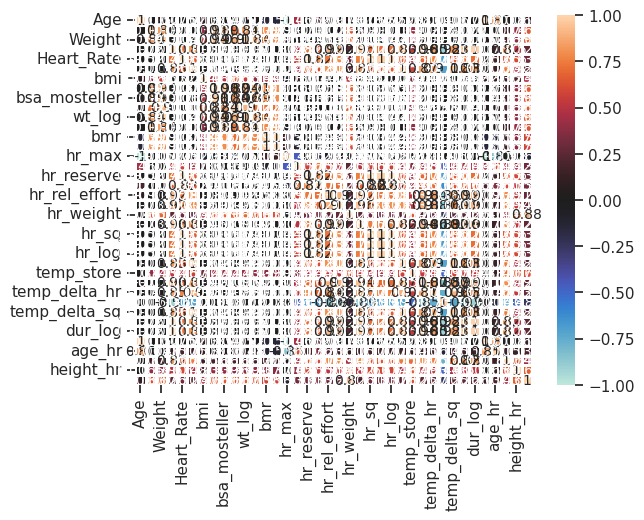

In [33]:
sns.heatmap(
    X_train_pp.corr("kendall", numeric_only=True),
    cmap="icefire", vmin=-1, vmax=1, center=0, lw=1,
    annot=True, annot_kws=dict(fontsize="small")
    )

In [34]:
er = skore.EstimatorReport(gr, fit=True, X_train=X_train_pp, y_train=y_train)
er.help()

╭───────────────────── Tools to diagnose estimator GroupRegressor ─────────────────────╮
│ EstimatorReport                                                                      │
│ ├── .metrics                                                                         │
│ │   ├── .timings(...)                  - Get all measured processing times related   │
│ │   │   to the estimator.                                                            │
│ │   ├── .custom_metric(...)            - Compute a custom metric.                    │
│ │   └── .report_metrics(...)           - Report a set of metrics for our estimator.  │
│ ├── .feature_importance                                                              │
│ │   └── .permutation(...)              - Report the permutation feature importance.  │
│ ├── .cache_predictions(...)            - Cache estimator's predictions.              │
│ ├── .clear_cache(...)                  - Clear the cache.                            │
│ ├── .get_predictions(...)              - Get estimator's predictions.                │
│ └── Attributes                                                                       │
│     ├── .X_train                       - Training data                               │
│     ├── .y_train                       - Training target                             │
│     ├── .estimator_                    - The cloned or copied estimator              │
│     ├── .estimator_name_               - The name of the estimator                   │
│     ├── .fit_time_                     - The time taken to fit the estimator, in     │
│     │   seconds                                                                      │
│     ├── .ml_task                       - No description available                    │
│     └── .pos_label                     - For binary classification, the positive     │
│         class                                                                        │
│                                                                                      │
│                                                                                      │
│ Legend:                                                                              │
│ (↗︎) higher is better (↘︎) lower is better                                             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [35]:
df_ = er.feature_importance.permutation(
    data_source="train",
    aggregate=False,
    scoring="rmse",
    seed=cfg.seed,
    n_jobs=cfg.n_jobs
    )

In [36]:
df_.index = X_train_pp.columns

<Axes: >

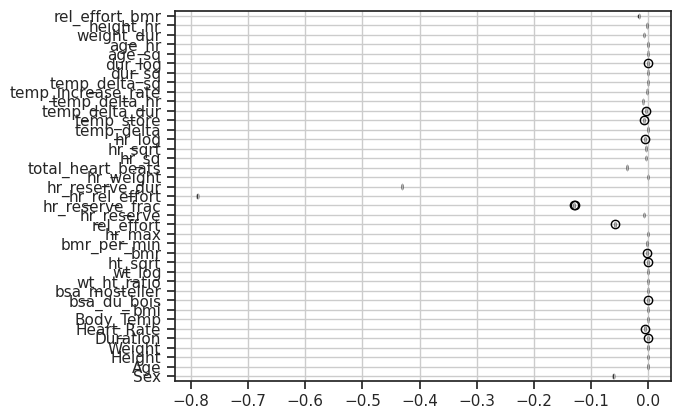

In [37]:
df_.T.boxplot(vert=False)

## Submission
---

In [38]:
def test_vote(model, X_train, y_train, X_test, cv):
    model_ = deepcopy(model)
    preds = []
    for train_idx, _ in cv.split(X_train, y_train):
        model_.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        preds.append(model_.predict(X_test))
        
    preds = np.array(preds).mean(axis=0)
    
    return preds

In [39]:
# preds = test_vote(cbr, X_train_pp, y_train, X_test_pp, KFold(3))
# preds = hgbr.predict(X_test_pp)
# preds.clip(1, inplace=True)

preds = test_vote(
    gr,
    X_train_pp,
    y_train,
    X_test_pp,
    KFold(3)
)
preds = np.expm1(preds)

In [40]:
y_test["Calories"] = preds  #hgbr.predict(X_test)
y_test.to_csv('submission.csv', index=False)
y_test.head()

,id,Calories
0,750000,27.013786
1,750001,108.374181
2,750002,87.617590
3,750003,125.225222
4,750004,76.436454


## Graveyard
---

In [41]:
# std_cols = ["Weight", "Height", "Heart_Rate"]
# norm_cols = ["Age", "Duration", "Body_Temp", "total_heart_beats"]

# col_tf = make_column_transformer(
#     (StandardScaler(), std_cols),
#     (MinMaxScaler(), norm_cols),
#     remainder="passthrough"
# )

# col_tf.fit(X_train_pp)
# col_tf.transform(X_test_pp)

In [42]:
# # CV before making GroupRegressor clonable
# cv_scores = []
# for train_idx, val_idx in KFold(5).split(X_train_pp):
#     gr_ = deepcopy(gr)
#     gr_.fit(X_train_pp.iloc[train_idx], y_train.iloc[train_idx])
#     y_pred_ = gr_.predict(X_train_pp.iloc[val_idx])
#     score_ = root_mean_squared_error(y_train.iloc[val_idx], y_pred_)
#     cv_scores.append(score_)
# cv_scores

In [43]:
# # scorer before processing target
# def rmsle(y_true, y_pred):
#     lhs = np.log(1 + y_pred.clip(min=1))
#     rhs = np.log(1 + y_true)
#     return np.sqrt(
#         np.mean((lhs - rhs)**2)
#     )

# rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [44]:
# # HGBR Finetuning
# def objective(trial):
#     learning_rate = trial.suggest_float("learning_rate", 1e-2, 1, log=True)
#     l2_regularization = trial.suggest_float("l2_regularization", 0, 1e2, log=False)
#     max_iter = trial.suggest_int("max_iter", 10, 1000, log=False)
#     max_depth = trial.suggest_int("max_depth", 2, 12, log=False)
#     max_bins = trial.suggest_int("max_bins", 32, 255, log=False)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 300, log=False)
    
#     hgbr.set_params(
#         learning_rate=learning_rate,
#         l2_regularization=l2_regularization,
#         min_samples_leaf=min_samples_leaf,
#         max_depth=max_depth,
#         max_iter=max_iter,
#         max_bins=max_bins
#     )

#     cv_scores = cross_val_score(
#         hgbr, X_train_pp, y_train,
#         n_jobs=cfg.n_jobs,
#         scoring=rmsle_scorer
#     )
#     return - cv_scores.mean()